In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [115]:
def innitializeParams(dims,activations):
    params={}
    params['L']=len(activations)+1
    for l in range(1,len(dims)):
        params['W'+str(l)]=np.random.randn(dims[l],dims[l-1])/np.sqrt(dims[l-1])  #Xavier initialization
        params['b'+str(l)]=np.random.randn(dims[l],1)/np.sqrt(dims[l-1])
        params['layer'+str(l)+'activationType']=activations[l-1]
    return params

In [13]:
def activationFunc(X,activationType):
    
    if activationType == "relu":
        Y=np.maximum(X,0)
    elif activationType == "sigmoid":
        Y=(np.tanh(X/2)+1)/2
    elif activationType == "tanh":
        Y=np.tanh(X)
    elif activationType == "linear":
        Y=X
    
    return Y

In [14]:
def activationGrad(X,activationType):
    
    if activationType == "relu":
        Y=(X>0)*1.0 # *1.0 converts bool to float
    elif activationType == "sigmoid":
        Y=(1.0 - np.square(np.tanh(X)))/4
    elif activationType == "tanh":
        Y=1.0 - np.square(np.tanh(X))
    elif activationType == "linear":
        Y=X/X
        
    return Y

In [154]:
def forwardPass(X,params,dropProbs=None):
    cache={}
    L=params['L']
    A_prev = X
    cache['A0']=X
    for l in range(1,L):
        Zl = np.dot(params['W'+str(l)],A_prev) + params['b'+str(l)]
        Al = activationFunc(Zl,params['layer'+str(l)+'activationType'])
        if dropProbs is not None:
            Dl = np.random.rand(*Al.shape)
            Dl = (Dl <= dropProbs[l-1])
            Al = Al*Dl
            Al = Al/dropProbs[l-1]
            cache['D'+str(l)] = Dl
            
        cache['Z'+str(l)] = Zl
        cache['A'+str(l)] = Al
        A_prev = Al
    y=A_prev
    
    return y,cache

In [16]:
def ComputeCost(Y,y,params,cost='mse',regularization='none',lamda=0.01):
    m=y.shape[1]
    if cost=='mse':
        Loss = np.sum(np.square(Y-y))/(2*m)
    elif cost=='cross-entropy':
        logprobs = np.multiply(-np.log(y),Y) + np.multiply(-np.log(1 - y), 1 - Y)
        Loss = (1./m)* np.nansum(logprobs)
    
    #regularisations
    L=params['L']
    for l in range(1,L):
        if regularization=='L2':
            Loss = Loss + lamda*np.sum(np.square(params['W'+str(l)]))/(2*m)
        elif regularization=='L1':
            Loss = Loss + lamda*np.sum(np.abs(params['W'+str(l)]))/(2*m)
    return Loss

In [129]:
def GradCost(Y,y,cost='mse'):    #depends on relgularizaton but will cancell anyways
    if cost=='mse':
        dy = y-Y
    elif cost=='cross-entropy':
        dy = (y-Y)/(y*(1-y))
    return dy

In [132]:
def backwardPass(Y,y,params,cache,dropProbs=None,cost='mse',regularization='none',lamda=0.01):
    
    dAl = GradCost(Y,y,cost)
    L=params['L']
    m=Y.shape[1]
    grads={}
    for l in reversed(range(1,L)):
        dZl = dAl*activationGrad(cache['Z'+str(l)],params['layer'+str(l)+'activationType'])
        grads['dW'+str(l)] = np.dot(dZl,cache['A'+str(l-1)].T)/m
        grads['db'+str(l)] = np.sum(dZl,axis=1,keepdims=True)/m
        
        if regularization=='L2':
            grads['dW'+str(l)] = grads['dW'+str(l)] + (lamda/m)*params['W'+str(l)]
        elif regularization=='L1':
            grads['dW'+str(l)] = grads['dW'+str(l)] + (lamda/m)*np.sign(params['W'+str(l)])
        dAl = np.dot(params['W'+str(l)].T,dZl)
    return grads  

In [113]:
def updateParams(params,grads,learningRate,optimizer='gd',beta=0.9,beta1=.9,beta2=.999,eps=1e-10):
    L=params['L']
    if optimizer == 'gradientDecent' or optimizer=='gd':
        for l in range(1,L):
            params['W'+str(l)] = params['W'+str(l)] - learningRate*grads['dW'+str(l)]
            params['b'+str(l)] = params['b'+str(l)] - learningRate*grads['db'+str(l)]
        
    elif optimizer=='momentum':            
        for l in range(1,L):
            if ('vdW'+str(l)) not in params:    #first time only
                params['vdW'+str(l)]=np.zeros(params['W'+str(l)].shape)
                params['vdb'+str(l)]=np.zeros(params['b'+str(l)].shape)
            #update velocity
            params['vdW'+str(l)] = beta*params['vdW'+str(l)] + (1-beta)*grads['dW' + str(l)]
            params['vdb'+str(l)] = beta*params['vdb'+str(l)] + (1-beta)*grads['db' + str(l)]
        
            params['W'+str(l)] = params['W'+str(l)] - learningRate*params['vdW'+str(l)]
            params['b'+str(l)] = params['b'+str(l)] - learningRate*params['vdb'+str(l)]
        
    elif optimizer=='rmsprop':
        for l in range(1,L):
            if ('sdW'+str(l)) not in params:    #first time only
                params['sdW'+str(l)]=np.zeros(params['W'+str(l)].shape)
                params['sdb'+str(l)]=np.zeros(params['b'+str(l)].shape)
            #update sq of magnitude of grads
            params['sdW'+str(l)] = beta*params['sdW'+str(l)] + (1-beta)*np.square(grads['dW' + str(l)])
            params['sdb'+str(l)] = beta*params['sdb'+str(l)] + (1-beta)*np.square(grads['db' + str(l)])
            
            params['W'+str(l)] = params['W'+str(l)] - learningRate*grads['dW'+str(l)]/np.sqrt(params['sdW'+str(l)]+eps)
            params['b'+str(l)] = params['b'+str(l)] - learningRate*grads['db'+str(l)]/np.sqrt(params['sdb'+str(l)]+eps)
        
    elif optimizer=='adam':
        for l in range(1,L):
            if ('vdW'+str(l)) not in params:    #first time only  for 'bias correction' 
                params['vdW'+str(l)]=grads['dW' + str(l)]
                params['vdb'+str(l)]=grads['db' + str(l)]
                params['sdW'+str(l)]=np.square(grads['dW' + str(l)])
                params['sdb'+str(l)]=np.square(grads['db' + str(l)])
            else:
                params['vdW'+str(l)] = beta*params['vdW'+str(l)] + (1-beta)*grads['dW' + str(l)]
                params['vdb'+str(l)] = beta*params['vdb'+str(l)] + (1-beta)*grads['db' + str(l)]
                params['sdW'+str(l)] = beta*params['sdW'+str(l)] + (1-beta)*np.square(grads['dW' + str(l)])
                params['sdb'+str(l)] = beta*params['sdb'+str(l)] + (1-beta)*np.square(grads['db' + str(l)])
            
            params['W'+str(l)] = params['W'+str(l)] - learningRate*params['vdW'+str(l)]/np.sqrt(params['sdW'+str(l)]+eps)
            params['b'+str(l)] = params['b'+str(l)] - learningRate*params['vdb'+str(l)]/np.sqrt(params['sdb'+str(l)]+eps)


In [133]:
def train(X,Y,params,steps,learningRate,optimizer='gd',cost='mse',regularization='none',lamda=0.01,dropProbs=None,showCost=False):
    for i in range(steps):
        y,cache = forwardPass(X,params,dropProbs)
        if showCost==True and i%200==0:
            print('step '+ str(i)+':'+str(ComputeCost(Y,y,params,cost,regularization,lamda)))
        grads = backwardPass(Y,y,params,cache,dropProbs,cost)
        updateParams(params,grads,learningRate,optimizer)

In [44]:
def normalise(X):
    mu = np.mean(X,axis=1,keepdims=True)
    sigma = np.sqrt(np.mean( np.square(X-mu),axis=1,keepdims=True ))
    X=(X-mu)/(sigma + 1e-10)
    return X,mu,sigma

step 0:1.40506922727
step 200:0.000464847689918
step 400:0.000166600132218
step 600:0.000133267008233
step 800:0.000138584828549


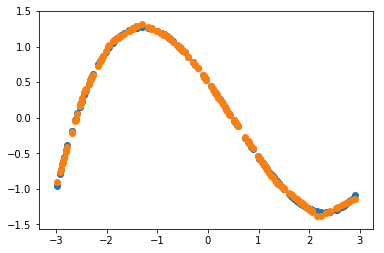

In [134]:
X = np.random.rand(1,200)*6 -3
Y = X**3/9 - X**2/6 - X + 0.5

params = innitializeParams([1,16,1],['relu','linear'])
Xhat,_,_ = normalise(X)
train(Xhat,Y,params,1000,0.01,optimizer='adam',showCost=True,cost='mse',regularization='none')

y,_ = forwardPass(Xhat,params)
plt.scatter(X,Y)
plt.scatter(X,y)
plt.show()


In [98]:
print()